In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [77]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [78]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [79]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [80]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [81]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [82]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

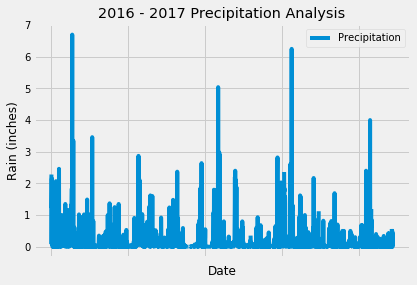

In [83]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastDate = session.query(func.max(Measurement.date)).scalar()
lastYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > lastYear).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
precip_df.set_index('date').head()
plt.rcParams.update({'font.size': 10})
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain (inches)")
plt.title("2016 - 2017 Precipitation Analysis")
plt.legend(["Precipitation"])
plt.savefig('Precipitation.png')
plt.show()

In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [85]:
# Design a query to show how many stations are available in this dataset?
totalStations = session.query(Measurement).group_by(Measurement.station).count()
print(f'There are {totalStations} stations in the dataset.')

There are 9 stations in the dataset.


In [86]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStns = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
for station, count in activeStns:
    print(station,count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [87]:
#Find the most active station
mostActiveStn = activeStns[0][0]    
print("The most active station was",mostActiveStn,"with",activeStns[0][1],"weather observations.")

The most active station was USC00519281 with 2772 weather observations.


In [88]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tempMostActive = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == mostActiveStn).all()
tempMostActive

[(54.0, 85.0, 71.66378066378067)]

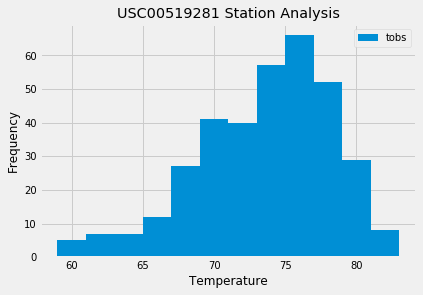

In [89]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
mostActiveTemps = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == mostActiveStn).filter(Measurement.date > lastYear).order_by(Measurement.date).all()

#...and plot the results as a histogram
temp_df=pd.DataFrame(mostActiveTemps)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"{mostActiveStn} Station Analysis")
plt.legend(["tobs"])
plt.savefig('Most Active Station Analysis')
plt.show()

In [90]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-07', '2017-06-14'))

[(72.0, 77.1923076923077, 83.0)]


In [91]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripStart = dt.date(2017, 6, 7)
tripEnd = dt.date(2017, 6, 14)
year = dt.timedelta(days=365)
tripTemps = (calc_temps((tripStart-year), (tripEnd-year)))
tripTemps

[(69.0, 75.43396226415095, 81.0)]

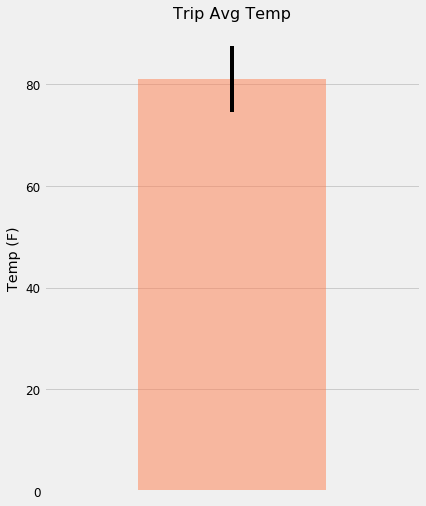

In [92]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.rcParams.update({'font.size': 12})
trip_df = pd.DataFrame(tripTemps, columns=['Min Temp', 'Max Temp', 'Avg Temp'])
avgTemp = trip_df['Avg Temp']
deltaTemp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avgTemp.plot(kind='bar', yerr=deltaTemp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=16)
plt.ylabel("Temp (F)")
plt.savefig("TripTempSummary.png")
plt.xticks([])
plt.show()

In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

totalPrecip = session.query(Station.station, func.sum(Measurement.prcp), Station.name, Station.elevation, Station.latitude, Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= tripStart)\
.filter(Measurement.date <= tripEnd)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())


for row in totalPrecip:
    rain=(row[1])
    print (f"Station:    {row[0]}\n Location:  {row[2]}\n Rainfall:  {rain}  \n Elevation: {row[3]}, Latitude:  {row[4]}, Longitude:  {row[5]}")
    print()       

Station:    USC00516128
 Location:  MANOA LYON ARBO 785.2, HI US
 Rainfall:  2.98  
 Elevation: 152.4, Latitude:  21.3331, Longitude:  -157.8025

Station:    USC00519281
 Location:  WAIHEE 837.5, HI US
 Rainfall:  2.08  
 Elevation: 32.9, Latitude:  21.45167, Longitude:  -157.84888999999998

Station:    USC00514830
 Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
 Rainfall:  1.34  
 Elevation: 7.0, Latitude:  21.5213, Longitude:  -157.8374

Station:    USC00513117
 Location:  KANEOHE 838.1, HI US
 Rainfall:  1.31  
 Elevation: 14.6, Latitude:  21.4234, Longitude:  -157.8015

Station:    USC00519523
 Location:  WAIMANALO EXPERIMENTAL FARM, HI US
 Rainfall:  0.6100000000000001  
 Elevation: 19.5, Latitude:  21.33556, Longitude:  -157.71139

Station:    USC00519397
 Location:  WAIKIKI 717.2, HI US
 Rainfall:  0.13999999999999999  
 Elevation: 3.0, Latitude:  21.2716, Longitude:  -157.8168

Station:    USC00517948
 Location:  PEARL CITY, HI US
 Rainfall:  None  
 Elevation: 11.9, Latitud

## Optional Challenge Assignment

In [94]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
tripRange = pd.date_range(tripStart, tripEnd)

# Stip off the year and save a list of %m-%d strings
trip_md = tripRange.strftime('%m-%d')

# push each tuple of calculations into a list called `normals`
normals = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_md:
    normals.append(*daily_normals(date))
normals

[(68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0)]

In [96]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = tripRange
normals_df = normals_df.set_index('Date')
normals_df

,Tmin,Tavg,Tmax
Date,,,
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0
2017-06-12,66.0,75.666667,83.0
2017-06-13,68.0,75.666667,81.0
2017-06-14,69.0,75.627119,81.0


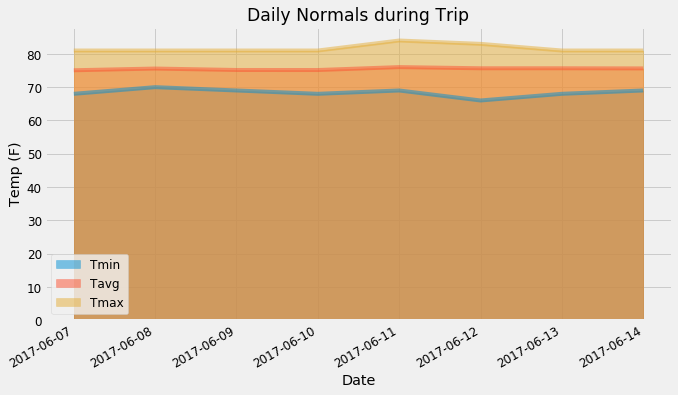

In [97]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, figsize=(10, 6))
#make the labels
plt.title('Daily Normals during Trip')
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.savefig('Daily Normals')
plt.show()